In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Read the training and test data sets, change paths if needed
train_df = pd.read_csv('all/train_sessions.csv')
test_df = pd.read_csv('all/test_sessions.csv')

# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54842,54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77291,77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114020,114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146669,146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"all/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [6]:
train_df.shape

(253561, 22)

In [7]:
test_df.shape

(82797, 21)

In [165]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


In [97]:
train_df = train_df.loc[train_df['target'] == 1]

# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


In [8]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']
time_df['session_id'] = train_df['session_id']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,session_id,min,max,seconds
21668,0,21669,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54842,0,54843,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77291,0,77292,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114020,0,114021,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146669,0,146670,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [216]:
train_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54842,54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77291,77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114020,114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146669,146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [217]:
time_df.loc[time_df['target'] == 1].mean()

target             1.000000
session_id    126149.746626
seconds           52.296474
dtype: float64

In [218]:
time_df.loc[time_df['target'] == 0].mean()

target             0.000000
session_id    126786.770779
seconds          139.282372
dtype: float64

In [209]:
(train_df.loc[time_df['target'] == 1].size / train_df.size) * 100

0.905896411514389

In [60]:
time_df.loc[time_df['target'] == 1].describe()

,target,session_id,seconds
count,2297.0,2297.000000,2297.000000
mean,1.0,126149.746626,52.296474
std,0.0,73710.279348,153.309014
min,1.0,153.000000,0.000000
25%,1.0,63062.000000,4.000000
50%,1.0,123879.000000,11.000000
75%,1.0,191806.000000,38.000000
max,1.0,253446.000000,1763.000000


In [61]:
time_df.loc[time_df['target'] == 0].describe()

,target,session_id,seconds
count,251264.0,251264.000000,251264.000000
mean,0.0,126786.770779,139.282372
std,0.0,73192.312917,296.653518
min,0.0,1.000000,0.000000
25%,0.0,63395.750000,7.000000
50%,0.0,126810.500000,28.000000
75%,0.0,190156.250000,114.000000
max,0.0,253561.000000,1800.000000


In [9]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [10]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
21668,56,55,0,0,0,0,0,0,0,0
54842,56,55,56,55,0,0,0,0,0,0
77291,946,946,951,946,946,945,948,784,949,946
114020,945,948,949,948,945,946,947,945,946,946
146669,947,950,948,947,950,952,946,951,946,947


In [11]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [12]:
full_sites_sparse.shape


(336358, 48371)

In [82]:
# How much memory does a sparse matrix occupy?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 14935184 bytes


In [194]:
#Mini Sparse Matrix Example

# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
mtx = csr_matrix((data, indices, indptr))
mtx.todense()

matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

In [236]:
mtx.toarray()

array([[2, 1, 0, 0, 0],
       [0, 2, 0, 1, 0],
       [0, 0, 1, 1, 1]])

In [13]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [14]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195245587148385
CPU times: user 8.14 s, sys: 316 ms, total: 8.46 s
Wall time: 4.42 s


In [15]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [16]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

In [76]:
# test_df['time1'] = test_df['time1'].apply(lambda ts: ts.year)
# test_df['time2'] = test_df['time2'].apply(lambda ts: ts.year)
# test_df['time3'] = test_df['time3'].apply(lambda ts: ts.year)
# test_df['time4'] = test_df['time4'].apply(lambda ts: ts.year)
# test_df['time5'] = test_df['time5'].apply(lambda ts: ts.year)
# test_df['time6'] = test_df['time6'].apply(lambda ts: ts.year)
# test_df['time7'] = test_df['time7'].apply(lambda ts: ts.year)
# test_df['time8'] = test_df['time8'].apply(lambda ts: ts.year)
# test_df['time9'] = test_df['time9'].apply(lambda ts: ts.year)
# test_df['time10'] = test_df['time10'].apply(lambda ts: ts.year)

# train_df['time1'] = train_df['time1'].apply(lambda ts: ts.year)
# train_df['time2'] = train_df['time2'].apply(lambda ts: ts.year)
# train_df['time3'] = train_df['time3'].apply(lambda ts: ts.year)
# train_df['time4'] = train_df['time4'].apply(lambda ts: ts.year)
# train_df['time5'] = train_df['time5'].apply(lambda ts: ts.year)
# train_df['time6'] = train_df['time6'].apply(lambda ts: ts.year)
# train_df['time7'] = train_df['time7'].apply(lambda ts: ts.year)
# train_df['time8'] = train_df['time8'].apply(lambda ts: ts.year)
# train_df['time9'] = train_df['time9'].apply(lambda ts: ts.year)
# train_df['time10'] = train_df['time10'].apply(lambda ts: ts.year)

# full_df['time1'].astype('int64')
# full_df['time2'].astype('int64')
# full_df['time3'].astype('int64')
# full_df['time4'].astype('int64')
# full_df['time5'].astype('int64')
# full_df['time6'].astype('int64')
# full_df['time7'].astype('int64')
# full_df['time8'].astype('int64')
# full_df['time9'].astype('int64')
# full_df['time10'].astype('int64')

train_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013,55,2013.0,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
54842,54843,56,2013,55,2013.0,56,2013.0,55,2013.0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
77291,77292,946,2013,946,2013.0,951,2013.0,946,2013.0,946,...,2013.0,948,2013.0,784,2013.0,949,2013.0,946,2013.0,0
114020,114021,945,2013,948,2013.0,949,2013.0,948,2013.0,945,...,2013.0,947,2013.0,945,2013.0,946,2013.0,946,2013.0,0
146669,146670,947,2013,950,2013.0,948,2013.0,947,2013.0,950,...,2013.0,946,2013.0,951,2013.0,946,2013.0,947,2013.0,0


In [74]:
test_df.groupby(['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']).size()

time1  time2   time3   time4   time5   time6   time7   time8   time9   time10
2014   2014.0  2014.0  2014.0  2014.0  2014.0  2014.0  2014.0  2014.0  2014.0    74806
dtype: int64

In [77]:
train_df.groupby(['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']).size()

time1  time2   time3   time4   time5   time6   time7   time8   time9   time10
2013   2013.0  2013.0  2013.0  2013.0  2013.0  2013.0  2013.0  2013.0  2013.0     67142
2014   2014.0  2014.0  2014.0  2014.0  2014.0  2014.0  2014.0  2014.0  2014.0    163910
dtype: int64

In [18]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [36]:
full_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
21668,21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54842,54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,...,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77291,77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,...,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114020,114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,...,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146669,146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,...,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [129]:
full_new_feat.groupby(['start_month']).size().plot()

start_month
201301.0      363
201302.0     3929
201303.0     3337
201304.0     3997
201305.0     3229
201306.0     2094
201307.0      139
201308.0      290
201309.0     3464
201310.0     2788
201311.0    34493
201312.0    16552
201401.0    35869
201402.0    55563
201403.0    56250
201404.0    31204
201405.0    25680
201406.0     4365
201407.0    10837
201408.0     7846
201409.0     3627
201410.0     8157
201411.0     9897
201412.0    12388
dtype: int64

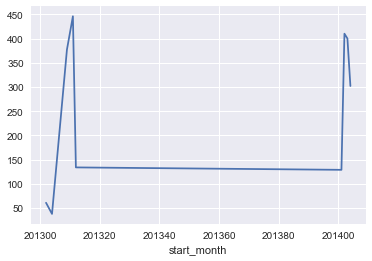

In [202]:

train_df = train_df.loc[train_df['target'] == 1]

# Dataframe for new features
full_new_feat = pd.DataFrame(index=train_df.index)

# Add start_month feature
full_new_feat['start_month'] = train_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

full_new_feat.groupby(['start_month']).size().plot()




In [19]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


In [20]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196830663159573


In [21]:

#train_df[sites].nunique(axis = 1)

# Dataframe for new features
feat_n_unique_sites = pd.DataFrame(index=full_df.index)

# Add  feature
feat_n_unique_sites['n_unique_sites'] = full_df[sites].nunique(axis = 1)

# Add the new feature to the sparse matrix
tmp = feat_n_unique_sites[['n_unique_sites']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9163638416687196


In [55]:
def add_morning_time_features(df): #, X_sparse
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')

    return df

In [56]:
def add_start_hour_time_features(df): #, X_sparse
    hour = df['time1'].apply(lambda ts: ts.hour).astype('int')  
    return df

In [22]:
#start_month and start_hour and morning

#full_new_feat_morning = pd.DataFrame(index=full_df.index)

full_new_feat['is_morning'] = full_df['time1'].apply(lambda ts: (ts.hour >= 7) & (ts.hour <= 11))

tmpMorning = full_new_feat[['is_morning']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmpMorning[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.9472961471481917


In [23]:
#full_new_feat_start = pd.DataFrame(index=full_df.index)

full_new_feat['session_start'] = full_df['time1'].apply(lambda ts: ts.hour)

tmpSessionStart = full_new_feat[['session_start']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmpSessionStart[:idx_split,:]]))

print(get_auc_lr_valid(X_train, y_train))

0.9561173215898826


In [24]:
# Compose the training set
full_new_feat.head()

,start_month,is_morning,session_start
21668,201301.0,True,8
54842,201301.0,True,8
77291,201301.0,True,8
114020,201301.0,True,8
146669,201301.0,True,8


In [25]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'session_start', 
                                                           'is_morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9591513080349163


In [36]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 10/10 [00:33<00:00,  6.12s/it]


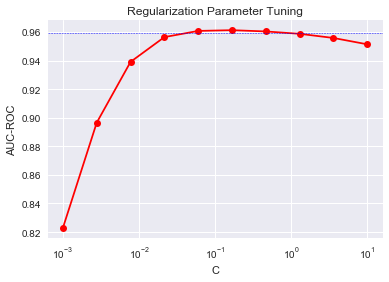

In [27]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

In [34]:
# List of possible C-values
Cs = np.logspace(0.17, 0.46, 1.29, 3.14)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


In [37]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

[0.8229644453864324, 0.8965353710466695, 0.9390416751204054, 0.9563605175378849, 0.960692001917791, 0.961212510687941, 0.960323660444715, 0.9586714074025766, 0.9557590944113541, 0.951324806530151]


In [41]:
score = get_auc_lr_valid(X_train, y_train, C=3.14)
print(score)

0.9562693379273365
